In [17]:
from dateutil import parser
from datetime import datetime
import geopandas as gpd
from imblearn.over_sampling import SMOTE
from importlib import reload
from itertools import combinations

from math import nan
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import networkx as nx
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from pathlib import Path
import pickle as pkl

import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, scale
from tqdm import tqdm
from IPython import get_ipython


import myprofiler as mp
import cleantools as clnt

# Introducion #

This file is for exploration, and converting of data.

In [2]:
def reporting(all_sheets):
    """This section takes a report of everything

    """
    print("Reporting each contracts sheet...")
    for name, df in tqdm(all_sheets.items()):
        mp.getReport(df, "_".join(name.split()))

Below are the basic variables defined to aid our process.

In [3]:
files = {
    "locations": "../data/locations_20200520_143742.xlsx",
    "persons": "../data/persons_20200520_143122.xlsx",
    "personMentions": "../data/person_mentions_20200520_143017.xlsx",
    "personRelationships": "../data/person_relationships_20200520_143219.xlsx",
    "professions": "../data/professions_20200520_143812.xlsx",
    "categories": "../data/profession_categories_20200520_143818.xlsx",
}
contracts_sheets = [
    "Contracts",
    "Person Mentions",
    "Hosting Conditions",
    "Financial Conditions",
    "Events",
]

Here is the report making and information extracting section.

In [ ]:
print("Extracting sheets from contracts...")
all_sheets = mp.readFromXlsx(
    "../data/contracts_20200520_142649.xlsx", contracts_sheets
)

print("Extracting Rest of the xlsx documents...")
for name, file in tqdm(files.items()):
    all_sheets[name] = mp.readFromXlsx(file)

print("Reporting all sheets...")
reporting(all_sheets)

# Cleaning The data #

Here I will prepare the data for further usage.

First, we read the pickles we create along the way.

In [18]:
all_sheets = clnt.loadPickle("../data/pickles/all_sheets.pkl")

Now, we take a look at the *Duration* data in the *Events* sheet. Since it is split to three sections, we turn it to one numeric value for easier processing.

In [180]:
# Processing for better information
# Merging different duration data into one numeric column
events = all_sheets["Events"].copy()
events["Duration - Merged"] = (
    events["Duration - Years"] * 365
    + events["Duration - Months"] * 30
    + events["Duration - Days"]
)
events.loc[events["Start Date"].astype(str).apply(lambda x:len(x.split("-"))) < 3, "Start Date"] = "0000-00-00"
clnt.savePickle(events, "../data/pickles/clean_events.pkl")

Secondly, we explore the ages of apprentices, after cleaning up the string formatted entries.

In [ ]:
# Exploring apprentice age from person Mentions
temp = all_sheets["Person Mentions"].copy()
temp["Age - Standard Form"] = temp.loc[
    temp["Age"].apply(lambda x: clnt.isInt(x)), "Age"
]
temp["Professions - Standard Form"] = temp[
    "Professions - Standard Forms"
].copy()
temp = clnt.cleanColumns(
    temp, to_go=["Professions - Standard Forms", "Age"], eliminate_list=["Transcript"]
)

# clnt.savePickle(temp, "../data/pickles/clean_mentions.pkl")

Now we restructure the professions data set to have easier usage

In [41]:
# Load dataframes
professions = all_sheets["professions"].copy()[["Standard Form", "Category ID"]]
categories = all_sheets["categories"].copy()[["ID", "Label", "Sectors", "Parent Category ID"]]
categories2 = categories.copy()[["ID", "Sectors", "Label"]]

# Merge necessary ones
categories_merged = categories.merge(categories2, left_on="Parent Category ID", right_on="ID", how="left")
categories_merged["Sectors"] = categories_merged["Sectors_x"].fillna(categories_merged["Sectors_y"])
categories_merged["Parent Label"] = categories_merged["Label_y"].fillna(categories_merged["Label_x"])
categories_merged = categories_merged[["ID_x", "Label_x", "Sectors", "Parent Label"]].copy()
categories_merged.columns = ["ID", "Label", "Sector", "Parent Label"]

# Reshape sectors to be numeric
categories_merged["Sector"] = categories_merged["Sector"].apply(lambda x:x.split(","))
categories = categories_merged.copy()[["ID", "Label", "Parent Label"]]
categories_merged = categories_merged.explode("Sector")
categories_sections = clnt.hotEncode(categories_merged,
                                     categories_merged.Sector,
                                     group="Label",
                                     operation="max")[["Label","S/T","T","P","S"]]
categories = categories.merge(categories_sections, on="Label")

# Add professions
professions = professions.merge(categories, left_on="Category ID",
                                right_on="ID", how="left")[["Standard Form",
                                                            "Category ID", "Label",
                                                            "Parent Label", "S/T",
                                                            "T", "P", "S"]]

# clnt.savePickle(professions, "../data/pickles/clean_professions_trimmed.pkl")

In [43]:
professions

,Standard Form,Category ID,Label,Parent Label,S/T,T,P,S
0,acconciar calze,158,cucitura e rammendatura,prod. e lav. di capi d'abbigliamento e accessori,0,0,0,1
1,acquaiol,210,trasporto: merci,trasporti e comunicazioni,0,1,0,0
2,acquavite,73,bevande,commercio all'ingrosso e al minuto,1,0,0,0
3,affitual da palada,69,trasporti e comunicazioni,trasporti e comunicazioni,0,1,0,0
4,agente,199,intermediazione e agenzia,servizi commerciali ed amministrativi,0,1,0,0
...,...,...,...,...,...,...,...,...
1676,zocoler,42,prod. di calzature,prod. di calzature,0,0,0,1
1677,zogeler,35,lav. di pietre e metalli preziosi e bigiotteria,lav. di pietre e metalli preziosi e bigiotteria,0,0,0,1
1678,zogeler intagiador,144,intaglio e/o incastonatura,lav. di pietre e metalli preziosi e bigiotteria,0,0,0,1
1679,zucarer,58,prod. e lav. di generi alimentari,prod. e lav. di generi alimentari,0,0,0,1


# Initial Analysis #
Here, I will various parts of the data to better understand it.

## Age Distribution ##
Simple Age distribution for all Apprentices.

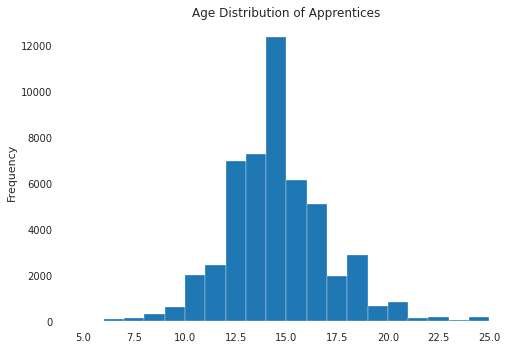

In [156]:
temp = temp[temp["Tag"] == "grz:Apprentice"]
clnt.plotHist(temp["Age - Standard Form"], atype=float,
              title="Age Distribution of Apprentices", range=[5,25],
              bins=20)

## Payment Distribution ##

The distribution of full payments in a common currency.

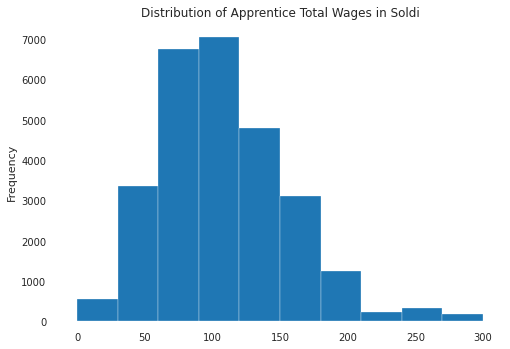

In [60]:
# Exploring the payment for apprenticeship
temp = all_sheets["Financial Conditions"].copy()
temp["Total - Standard Form"] = temp["Total Amount"] * temp[
    "Currency"
].apply(lambda x: clnt.currencyMap(x))
temp["Partial - Standard Form"] = temp["Partial Amount"] * temp[
    "Currency"
].apply(lambda x: clnt.currencyMap(x))
# clnt.savePickle(temp, "../data/pickles/clean_Financial.pkl")
clean_money = temp[temp["Paid in Goods"] == False]
clean_money = clean_money[clean_money["Paid by"] == "grz:MasterPayer"]

# After some experiment, this seems to be the best rate for visualization
clnt.plotHist(
    clean_money.loc[
        clean_money["Total - Standard Form"] > 0,
        "Total - Standard Form"],
    range=[0, 300], title="Distribution of Apprentice Total Wages in Soldi"
)



## Average Ages per Profession ##
Average age per distribution is extracted and made easy to access.

In [73]:
mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")
professions = all_sheets["professions"].copy()
temp = pd.merge(mentions[["Age - Standard Form", "Professions - Standard Form"]],
         professions[["Standard Form", "Category ID"]],
         left_on="Professions - Standard Form",
         right_on="Standard Form")
categories = all_sheets["categories"].copy()
temp = pd.merge(temp,
                categories[["Label", "Extended Label", "ID"]],
                left_on="Category ID", right_on="ID")[["Age - Standard Form",
                                                       "Professions - Standard Form",
                                                       "Label", "Extended Label"]]
temp["Age - Standard Form"] = pd.to_numeric(temp["Age - Standard Form"])

grouped_age = temp[["Age - Standard Form", "Label"]].groupby(["Label"]).agg(["mean", "count"])
grouped_age[(grouped_age[("Age - Standard Form", "mean")] > -1) &
            (grouped_age[("Age - Standard Form", "count")] > 20)].sort_values(("Age - Standard Form", "mean"), ascending=False)
# clnt.savePickle(grouped_age, "../data/pickles/age_with_prof_categories.pkl")

## Geo Origin Counts against the Profession ##

This section, due to its variant nature couldn't be analyzed as one frame, so I created a frame per profession for easy exploration.

In [238]:
# Get the mapping of profession to where they come from, for only
# apprentices
mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")
professions = all_sheets["professions"].copy()
temp = pd.merge(mentions[["Geo Origin - Standard Form", "Professions - Standard Form"]],
         professions[["Standard Form", "Category ID"]],
         left_on="Professions - Standard Form",
         right_on="Standard Form")
temp = pd.merge(temp,
                categories[["Label", "ID"]],
                left_on="Category ID", right_on="ID")[["Geo Origin - Standard Form",
                                                       "Label"]]


geo_counts = dict()
u = temp["Label"].unique()
for label in tqdm(u):
    geo_counts[label] = temp[
        temp["Label"] == label].groupby([
        "Geo Origin - Standard Form"
    ]).size().to_frame(name = 'count').reset_index()
# clnt.savePickle(geo_counts, "../data/pickles/profession_labels_with_province_counts_dict.pkl")

100%|██████████| 173/173 [00:01<00:00, 136.00it/s]


## Profession's Affect on Income ##

First, I connect profession with a category label, then we average it and group it with the category label.

In [27]:
# Get the necessary datasets and exclude unnecessary variables
mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")
apprentices = mentions[mentions["Tag"] == "grz:Apprentice"]
apprentices_trimmed = apprentices[["Contract ID", "Professions - Standard Form"]]
finances = clnt.loadPickle("../data/pickles/clean_Financial.pkl")[["Contract ID",
                                                                   "Total - Standard Form"]]
professions = all_sheets["professions"].copy()[["Standard Form", "Category ID"]]
categories = all_sheets["categories"].copy()[["ID", "Label"]]


# Merge the right connections
labels = pd.merge(professions, categories, left_on="Category ID", right_on="ID")[["Standard Form", "Label"]]
# clnt.savePickle(labels, "../data/pickles/profession_standards_to_label.pkl")

apprentices_trimmed = pd.merge(apprentices_trimmed, labels,
                               left_on="Professions - Standard Form",
                               right_on="Standard Form")[["Contract ID",
                                                          "Professions - Standard Form",
                                                          "Label"]]
jobs_w_pays = pd.merge(apprentices_trimmed, finances, on="Contract ID")
jwp_grouped = jobs_w_pays[["Label", "Total - Standard Form"]].groupby(["Label"]).agg(["mean","count"]).reset_index()
jwp_grouped[(jwp_grouped[("Total - Standard Form", "count")] > 5) &
            (jwp_grouped[("Total - Standard Form", "mean")] > 1)].sort_values(("Total - Standard Form", "mean"),
                                                                              ascending=False).head(10)

Label Total - Standard Form      
                                                              mean count
33                         editoria e stampa            767.857143     7
42              fabbr. di strumenti musicali            409.821429    28
30                              distillatura            249.615385    13
119                                purgatura            179.166667     6
60             impiallacciatura e/o intarsio            127.537879   132
56     fornitura di materiali per l'edilizia            119.873418    79
95                                     pelli            118.593750    32
152                         trasporto: merci            118.154762    84
4              altre tipologie merceologiche            116.336066   610
71   lavorazione della pietra per l'edilizia            115.415385   975

## Age's Effect on Income ##
I explore the correlation between age of total income, then normalize it to monthly income.

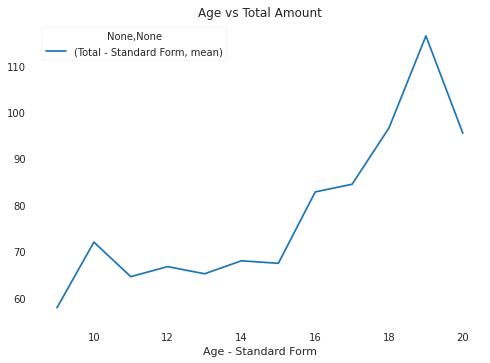

In [137]:
# Get necessary dataframes
mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")
apprentices = mentions[mentions["Tag"] == "grz:Apprentice"]
apprentices_trimmed = apprentices[["Contract ID", "Age - Standard Form"]]
finances = clnt.loadPickle("../data/pickles/clean_Financial.pkl")[["Contract ID",
                                                                   "Total - Standard Form",
                                                                   "Paid by"]]
# Merging Process
age_w_money = pd.merge(apprentices_trimmed, finances, on="Contract ID")
age_w_money["Age - Standard Form"] = pd.to_numeric(age_w_money["Age - Standard Form"])
age_w_money = age_w_money[age_w_money["Paid by"] == "grz:MasterPayer"][["Age - Standard Form",
                                                                        "Total - Standard Form"]]
# Group and exclude non-master pays
age_w_money = age_w_money.groupby(["Age - Standard Form"]).agg(["mean", "count"]).reset_index()
awm_trimmed = age_w_money[(age_w_money[("Total - Standard Form", "count")] > 500) &
                          (age_w_money[("Total - Standard Form", "mean")] > 0)]
awm_trimmed.plot.line("Age - Standard Form", ("Total - Standard Form", "mean"),
                      title="Age vs Total Amount")

This graph is regardless of the time duration. Assuming all ages have done all amounts of apprenticeship time, the graph above should be accurate. However, since this is a big assumption, we are going to normalize the amount to per month.

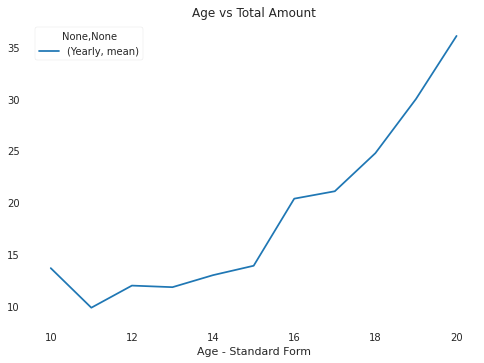

In [138]:
# Load dataframes
events = clnt.loadPickle("../data/pickles/clean_events.pkl")
age_w_money = pd.merge(apprentices_trimmed, finances, on="Contract ID")
age_w_money = pd.merge(age_w_money, events, on="Contract ID")

# Exclude unnecessary sections, and adjust to time
awm_timed = age_w_money[age_w_money["Paid by"] == "grz:MasterPayer"]
awm_timed = awm_timed[(awm_timed["Duration - Merged"] > 0) &
                      (awm_timed["Total - Standard Form"] < 9999999)]
awm_timed["Yearly"] = awm_timed["Total - Standard Form"] / awm_timed["Duration - Merged"] * 365
awm_timed = awm_timed[["Age - Standard Form", "Yearly", "Total - Standard Form", "Duration - Merged"]]
awm_timed.sort_values("Yearly", ascending = False)
awm_timed = awm_timed[["Age - Standard Form", "Yearly"]]

# Group and plot
awm_grouped = awm_timed.groupby(["Age - Standard Form"]).agg(["mean", "count"]).reset_index()
# awm_grouped.sort_values(("Yearly", "count"), ascending = False)
awm_grouped = awm_grouped[(awm_grouped[("Yearly", "mean")] > 0) &
                          (awm_grouped[("Yearly", "mean")] < 9999999) &
                          (awm_grouped[("Yearly", "count")] > 450)]
awm_grouped.plot.line("Age - Standard Form", ("Yearly", "mean"),
                      title="Age vs Monthly Amount")

## Formatting the data in a different manner ##
I create two main structures to analyze the data easier, and profile it. One is a table based on Contract ID, and the other is a group of data frames based on Contract ID, holding information about people in the contract.

### The Main Table ###

Here we generate one table of contracts and integrate only the sections that we will focus on in the main search, and do a deep analysis of it with correlation checks.

The table will include:

- Contract ID
- Master(s)
- Apprentice
- Any extra people
- Is there money exchange
- Does Master Pay
- Is the payment period whole?
- Is the origin in italy?
- What type of place
- Where is the origin

In [19]:
def conv(x):
    freq='D'
    year = x.year
    month = x.month
    day = x.day
    return pd.Period(year=year, month=month, day=day, freq=freq)

def fixDate(x):
    alst = x.split("-")
    if len(alst) < 3:
        return datetime.strptime("0001-01-01", "%Y-%m-%d")
    asum = 0
    for n in range(len(alst)):
        el = int(alst[n])
        if el == 0:
            alst[n] = str(el + 1)
        asum += el
    if asum == 0:
        return datetime.strptime("0001-01-01", "%Y-%m-%d")
    x = "-".join(alst)
    try:
        return datetime.strptime(x, "%Y-%m-%d")
    except:
        return datetime.strptime("0001-01-01", "%Y-%m-%d")

def dateLine(x):
    s = x.copy()
    s = s.apply(fixDate)
    return pd.PeriodIndex(s.apply(conv))

def shiftDate(x):
    alst = str(x).split("-")
    if len(alst) == 3:
        alst[0] = str(int(alst[0])+200)
    return "-".join(alst)
    

In [20]:
# Load dataframes
contracts = all_sheets["Contracts"].copy()[["Contract ID",
                                            "Date"]]
events = clnt.loadPickle("../data/pickles/clean_events.pkl")[["Contract ID",
                                                              "Tag",
                                                              "Duration - Merged"]]
financials = clnt.loadPickle("../data/pickles/clean_Financial.pkl")[["Contract ID",
                                                                     "Tag",
                                                                     "Paid by",
                                                                     "Paid in Goods",
                                                                     "Periodization",
                                                                     "Currency",
                                                                     "Total Amount"]]
hosting = all_sheets["Hosting Conditions"][["Contract ID",
                                            "Tag",
                                            "Paid by",
                                            "Paid in Goods"]].copy()
locations = all_sheets["locations"][["Historical Name",
                                    "Province",
                                    "Country"]].copy()
mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")[["Contract ID",
                                                                  "Gender",
                                                                  "Age - Standard Form",
                                                                  "Geo Origin - Standard Form",
                                                                  "Workshop - Site",
                                                                  "Professions - Standard Form",
                                                                  "Person ID",
                                                                  "Tag"]]

In [21]:
# Prepare each row for easier understanding
# TODO: Dont forget to convert dates to datetime in the end
# Turn events into one-hot encoding on three different column
contracts.columns = ["Contract ID", "Contract Date"]
events_tags = clnt.hotEncode(events, events.Tag, operation="max")
events_tags = events_tags.loc[events_tags["grz:Apprenticeship"] != 0,
                              ["Contract ID", "grz:BreachOfContract", "grz:Flee"]]
events_tags.columns = ["Contract ID", "Has BoContract", "Has Flee"]
the_table = pd.merge(contracts, events_tags, on = "Contract ID", how="left")

# events[(events["Tag"]!= "grz:Apprenticeship") & (events["Duration - Merged"].astype(float) > 0)]
# After the check above, its been deciced that the events with duration which are not apprenticeships
# are very little, so they can be ignored
# On the other hand, breach and flee dates are pretty abundant, neet to incorparate them in.

In [22]:
# Financial Tags extracted to encoding
financial_tags = clnt.hotEncode(financials, financials.Tag, operation="max")
financial_tags = financial_tags[["Contract ID", "grz:SingleSalary"]]
financial_tags.columns = ["Contract ID", "Has Single Salary"]
the_table = the_table.merge(financial_tags, on="Contract ID", how="left")

In [23]:
# Financial Paid by extracted
financial_paidby = clnt.hotEncode(financials, financials["Paid by"], operation="max")[["Contract ID", "grz:MasterPayer"]]
financial_paidby.columns = ["Contract ID", "Has Master Paying Salary"]
the_table = the_table.merge(financial_paidby, on="Contract ID", how="left")

In [24]:
# Financial Periodization
financial_periodization = clnt.hotEncode(financials, financials.Periodization, operation="max")[["Contract ID", "grz:WholePeriod"]]
financial_periodization.columns = ["Contract ID", "Has Whole Period"]
the_table = the_table.merge(financial_periodization, on="Contract ID", how="left")

In [25]:
# Financial Currency
financial_currency = clnt.hotEncode(financials, financials.Currency, operation="max")[["Contract ID", "grz:Ducati"]]
financial_currency.columns = ["Contract ID", "Has Ducati"]
# financial_currency.columns = ["Contract ID", "Has Ducati", "Has Soldi", "Has Lire", "Has Other Currency"]
the_table = the_table.merge(financial_currency, on="Contract ID", how="left")

In [26]:
# Hosting Paid by
temp = hosting[hosting["Paid in Goods"] == False]
# hosting_paid = clnt.hotEncode(temp, temp["Paid by"])
# hosting_paid.columns = ["Contract ID", "Apprentice Paid", "Master Paid", "Others Paid"]
# the_table = the_table.merge(hosting_paid, on="Contract ID", how="left")

In [27]:
# Hosting Apprentice Paid
temp = temp[temp["Paid by"] == "grz:MasterPayer"]
master_tag = clnt.hotEncode(temp, temp.Tag, operation="max")
master_tag.columns = ["Contract ID", "Master Paid Accom", "Master Paid Clothing", "Master Paid Gen. Exp.", "Master Paid Per. Care"]
the_table = the_table.merge(master_tag, on="Contract ID", how="left")

In [28]:
# Mentions Details
mentions_slice = mentions[mentions["Tag"] == "grz:Apprentice"].drop_duplicates("Contract ID")
mentions_slice["Geo Origin - Standard Form"] = mentions_slice["Geo Origin - Standard Form"].fillna("Venezia")
mentions_slice = mentions_slice.merge(locations, left_on="Geo Origin - Standard Form",
                                      right_on="Historical Name", how="left")

# Is Italian?
mentions_country = clnt.hotEncode(mentions_slice, mentions_slice.Country, operation="max")[["Contract ID", "Italy"]]
mentions_country.columns = ["Contract ID", "From Italy"]
mentions_slice = mentions_slice.merge(mentions_country,
                                      on="Contract ID", how="left")

# Gender hotcoding
mentions_gender = clnt.hotEncode(mentions_slice, mentions_slice.Gender, operation="max")
mentions_slice = mentions_slice.merge(mentions_gender[["Contract ID", "grz:Male"]],
                                      on="Contract ID", how="left")
# Lose unimportant parts
mentions_slice = mentions_slice[["Contract ID", "Age - Standard Form", "Geo Origin - Standard Form",
                                 "Workshop - Site", "Professions - Standard Form", "Province",
                                 "Person ID", "grz:Male", "From Italy"]]

mentions_slice.columns = ["Contract ID", "Apprentice Age", "Apprentice Geo Origin",
                          "Workshop - Site", "Apprentice Profession", "Apprentice Province", 
                          "Apprentice ID", "Apprentice Male", "From Italy"]
the_table = the_table.merge(mentions_slice, on="Contract ID", how="left")

In [29]:
# Adding profession details
professions = clnt.loadPickle("../data/pickles/clean_professions_trimmed.pkl")
the_table = the_table.merge(professions, left_on="Apprentice Profession",
                            right_on= "Standard Form", how="left")

In [30]:
# Adding further details
events_slice = events.loc[events["Tag"] == "grz:Apprenticeship",
                           ["Contract ID","Duration - Merged"]].drop_duplicates("Contract ID")
the_table = the_table.merge(events_slice, on="Contract ID", how="left")

financials_slice = financials[["Contract ID", "Paid in Goods", "Total Amount"]].drop_duplicates("Contract ID")
financials_slice.columns = ["Contract ID", "Paid Salary in Goods", "Total Payment Received"]
the_table = the_table.merge(financials_slice, on="Contract ID", how="left")

# # Formatting and indexing
the_table["Contract Date"] = pd.to_datetime(the_table["Contract Date"].apply(shiftDate), errors="coerce")
the_table["Apprentice Age"] = pd.to_numeric(the_table["Apprentice Age"], errors="coerce")
the_table = the_table[['Contract Date', 'Has BoContract', 'Has Flee', 'Has Single Salary',
                       'Has Master Paying Salary', 'Has Whole Period', 'Has Ducati',
                       'Master Paid Accom', 'Master Paid Clothing', 'Master Paid Gen. Exp.',
                       'Master Paid Per. Care', 'Apprentice Age', 'Apprentice Geo Origin',
                       'Workshop - Site', 'Apprentice Profession', 'Apprentice Province',
                       'Apprentice ID', 'Apprentice Male', 'From Italy', 'Contract ID',
                       'Label', 'Parent Label', 'S/T', 'T', 'P', 'S',
                       'Duration - Merged', 'Paid Salary in Goods', 'Total Payment Received']]
the_table = the_table.set_index("Contract ID")
the_table

,Contract Date,Has BoContract,Has Flee,Has Single Salary,Has Master Paying Salary,Has Whole Period,Has Ducati,Master Paid Accom,Master Paid Clothing,Master Paid Gen. Exp.,...,From Italy,Label,Parent Label,S/T,T,P,S,Duration - Merged,Paid Salary in Goods,Total Payment Received
Contract ID,,,,,,,,,,,,,,,,,,,,,
01213dcc-5cff-415e-8d6e-91150828ce30,NaT,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,fabbr. e lav. di oggetti in vetro,fabbr. e lav. di oggetti in vetro,1.0,0.0,0.0,0.0,1825.0,NaN,NaN
0fa08eb4-21f2-4838-a22d-32dd29378fd0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,...,1.0,falegnameria,falegnameria,0.0,0.0,0.0,1.0,NaN,NaN,NaN
10131a7c-49fa-4b62-a163-f03bfe73f8f0,NaT,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,fabbr. e lav. di oggetti in vetro,fabbr. e lav. di oggetti in vetro,1.0,0.0,0.0,0.0,1825.0,NaN,NaN
16a71f89-1278-43de-abb7-9d378bcc4d44,NaT,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,fabbr. e lav. di oggetti in vetro,fabbr. e lav. di oggetti in vetro,1.0,0.0,0.0,0.0,1825.0,NaN,NaN
17dd187e-c8b2-4bc5-94eb-cdc68a97f8c7,NaT,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,falegnameria,falegnameria,0.0,0.0,0.0,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ccda404b-95ff-46fb-b491-177e2a1de4c8,1972-05-09,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1.0,tessitura,prod. e lav. di tessuti e filati,0.0,0.0,0.0,1.0,2190.0,False,0.0
40f49aa3-bff4-4221-a22a-801df6f7c899,1972-05-13,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1.0,prod. e lav. di generi alimentari,prod. e lav. di generi alimentari,0.0,0.0,0.0,1.0,1460.0,False,0.0
da38eb53-b74b-42e6-ae03-5f978fcb12d3,1972-05-19,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2190.0,False,0.0


In [31]:
# Check the status of the profile
profiler = ProfileReport(the_table, title="All Necessary Data Profile Report")
# Save the results to a pickle
clnt.savePickle(the_table, "../data/pickles/table_of_all.pkl")
profiler.to_file("../reports/The_Table_Profile_Report.html")
profiler

### Sub-tables to store people connected to each contract ###

Here, we will store other people who are a part of the contract, and put all these information in pandas groups.

Each group will have these columns:

- Is Master
- Profession
- Worksite
- Geo Origin
- Gender

In [253]:
# Load frames
person_relations = all_sheets["personRelationships"]
mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")

# Set Constants
to_from = {
    "Father": "Child",
    "father": "child",
    "Aunt": "NepSmt",
    "Uncle": "NepSmt",
    "Mother": "Child",
    "mother": "child",
    "Daughter": "Parent",
    "Son": "Parent",
    "daughter": "parent",
    "son": "parent",
    "Widow": "Widower",
    "Widower": "Widow",
    "AdopterOf": "AdoptedBy",
    "Husband": "Wife",
    "Brother": "Sibling",
    "brother": "sibling",
    "Daughter": "Sibling",
    "daughter": "sibling"
}

gender_fix = {
    "Childgrz:Male": "Son",
    "childgrz:Male": "son",
    "Childgrz:Female": "Daughter",
    "childgrz:Female": "daughter",
    "NepSmtgrz:Male": "Nephew",
    "NepSmtgrz:Female": "Niece",
    "Parentgrz:Male": "Father",
    "parentgrz:Male": "father",
    "Parentgrz:Female": "Mother",
    "parentgrz:Female": "mother",
    "Siblinggrz:Male": "Brother",
    "siblinggrz:Male": "brother",
    "Siblinggrz:Female": "Sister",
    "siblinggrz:Female": "sister",
}

fixables = ["child", "nepsmt", "parent", "sibling"]


def changePers(x, g):
    """Takes in a relation from person 1 to person 2 and the gender of person 1. Returns the relation
    in perspective of person 2"""
    x_temp = x[5:]
    if isinstance(x, float) or isinstance(g, float):
        return x
    for key in to_from.keys():
        if key in x_temp and to_from[key].lower() in fixables:
            x_temp = x_temp.replace(key, gender_fix[to_from[key]+g])
        elif key in x_temp:
            x_temp = x_temp.replace(key, to_from[key])
            break
    return x[:5]+x_temp

# Get relations from apprentice to people
person_relations_1 = person_relations.merge(mentions, left_on="Person 1 ID", right_on="Person ID", how="left")
person_relations_1 = person_relations_1[person_relations_1["Tag"] == "grz:Apprentice"][["Person 2 ID", "Relationship Type"]]

# Get relations from people to apprentice
person_relations_2 = person_relations.merge(mentions[["Person ID", "Tag"]], left_on="Person 2 ID", right_on="Person ID", how="left")
person_relations_2 = person_relations_2.merge(mentions[["Person ID", "Gender"]], left_on="Person 1 ID", right_on="Person ID", how="left")
person_relations_2 = person_relations_2[person_relations_2["Tag"] == "grz:Apprentice"][["Person 1 ID", "Relationship Type", "Gender"]]

# Convert them to "from apprentice" form
person_relations_2["Relationship Type"] = person_relations_2.apply(lambda x: changePers(x['Relationship Type'], x['Gender']), axis=1)

# Merge both lists
person_relations_m = person_relations_1.merge(person_relations_2, left_on="Person 2 ID", right_on="Person 1 ID", how="outer")
person_relations_m["Relationship Type_x"] = person_relations_m["Relationship Type_x"].fillna(person_relations_m["Relationship Type_y"])
person_relations_m["Person 2 ID"] = person_relations_m["Person 2 ID"].fillna(person_relations_m["Person 1 ID"])

# Fix formatting issues
person_relations_m = person_relations_m[["Person 2 ID", "Relationship Type_x"]]
person_relations_m.columns = ["Person ID", "Relationship From Apprentice"]
person_relations_m

,Person ID,Relationship From Apprentice
0,38f1b3fe-857c-4dad-97cd-aa80eb5e70bb,grz:isSonOf
1,4a7e7333-8bf7-4514-993f-0ea3f953fa91,grz:isSonOf
2,c64f5c72-75ca-456c-b8eb-39b3c943fcdc,grz:isSonOf
3,8c9dfa72-66e9-40d6-b202-c3274342d040,grz:isSonOf
4,ee68dcbc-dbc7-4949-9fd2-3b68957f7c87,grz:isSonOf
...,...,...
63697,f4cc3c6a-6706-4127-b5a8-9c0906faaa36,grz:isBrotherOf
63698,cd637d1a-18a7-41b1-8c33-fdb41ad21ee3,grz:isFatherOf
63699,f8fd0f70-5432-43fa-af39-82464360cf17,grz:isFatherOf
63700,775a9920-c939-46a4-96bc-7a233001b159,grz:isBrotherOf


In [188]:
# Load the frame
mentions = mentions[["Contract ID", "Gender", "Geo Origin - Standard Form",
                     "Workshop - Site", "Professions - Standard Form",
                     "Person ID", "Person Name","Tag"]]
mentions["Tag"] = mentions["Tag"].apply(lambda x:1 if x == "grz:Master" else 0)
mentions = mentions[mentions["Person ID"].notna()]
mentions = mentions.merge(the_table.reset_index()[["Contract ID", "Apprentice ID"]], on="Contract ID", how="left")
mentions.merge(names, left_on=["Person ID", "Apprentice ID"], right_on=
# sub_tables = mentions.groupby("Contract ID")
# clnt.savePickle(sub_tables, "../data/pickles/sub_tables.pkl")

,Contract ID,Gender,Geo Origin - Standard Form,Workshop - Site,Professions - Standard Form,Person ID,Person Name,Tag,Apprentice ID
0,01213dcc-5cff-415e-8d6e-91150828ce30,grz:Male,Friuli (area),NaN,spechier,fafcc84f-de4e-4636-8c89-22058560047f,Domenico Del Zotto,0,fafcc84f-de4e-4636-8c89-22058560047f
1,01213dcc-5cff-415e-8d6e-91150828ce30,grz:Male,NaN,NaN,spechier,a138e6c6-7379-489d-a6a1-6a8b546ee5fe,Iseppo Bianchi,1,fafcc84f-de4e-4636-8c89-22058560047f
2,0fa08eb4-21f2-4838-a22d-32dd29378fd0,grz:Male,Ampezzo,NaN,marangon,351ea658-3833-4091-98ba-80b4309b5410,Bartolomeo Da Col 172599,0,351ea658-3833-4091-98ba-80b4309b5410
3,0fa08eb4-21f2-4838-a22d-32dd29378fd0,grz:Male,NaN,NaN,marangon,7aac65a3-c9a8-475d-bc7e-437c36f6c38a,Giovanni Cauff,1,351ea658-3833-4091-98ba-80b4309b5410
4,0fa08eb4-21f2-4838-a22d-32dd29378fd0,grz:Male,NaN,NaN,marangon,a98e92f7-cef0-409a-bf15-314b8a9e3e91,Marco Cauff,1,351ea658-3833-4091-98ba-80b4309b5410
...,...,...,...,...,...,...,...,...,...
156083,da38eb53-b74b-42e6-ae03-5f978fcb12d3,grz:Male,NaN,NaN,"bariler, masteler",7038912f-e635-44d3-a673-6727be88589b,Daniele Caliari,1,afa21e67-b402-48e3-ae3d-9604e5004ee8
156084,b89c26a8-24fc-4bb3-9b23-607faa10b082,grz:Male,Cividale di Belluno,NaN,luganegher,52e319a8-fb2d-4b86-8b1b-98ffa163d4cd,Giacomo De Donà,0,52e319a8-fb2d-4b86-8b1b-98ffa163d4cd
156085,b89c26a8-24fc-4bb3-9b23-607faa10b082,grz:Male,NaN,NaN,luganegher,bd57bdf1-a906-40e3-ad2d-3d65c481426e,Antonio Folador,1,52e319a8-fb2d-4b86-8b1b-98ffa163d4cd
156086,af710400-2376-4534-b4e8-c44246c114dd,grz:Male,Zoldo,NaN,forner,7e96deeb-f003-4456-86a8-452fd1b0e418,Paolo Antonio Rizzardini,0,7e96deeb-f003-4456-86a8-452fd1b0e418


## Plotting Various Results ##
Here, I delve a bit deeper and explore various sub sections.

### Province Count against Sectors and Top Sector Professions ###

In [152]:
provenance_sector_profession = the_table[["Apprentice Province", "Apprentice Profession", "Contract Date",
                                          "S/T", "T", "P", "S"]].copy()
sectors = ["S/T", "S", "T", "P"]

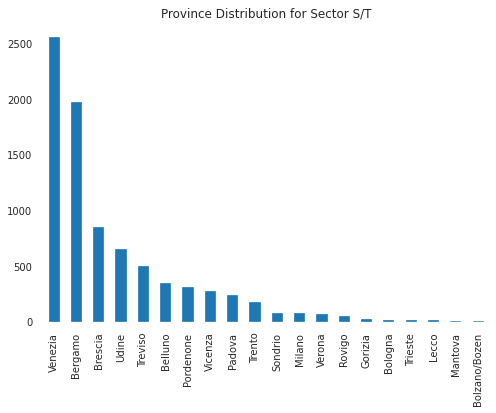

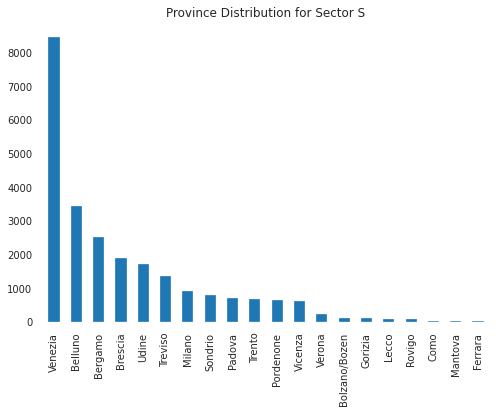

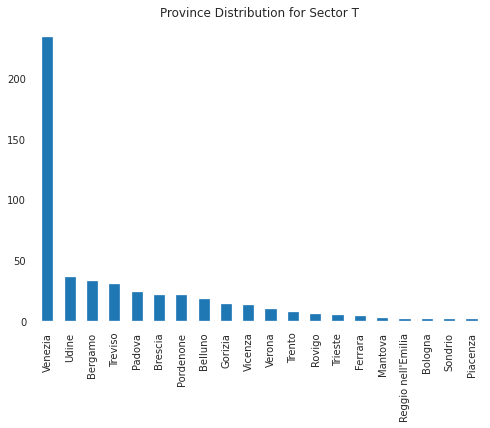

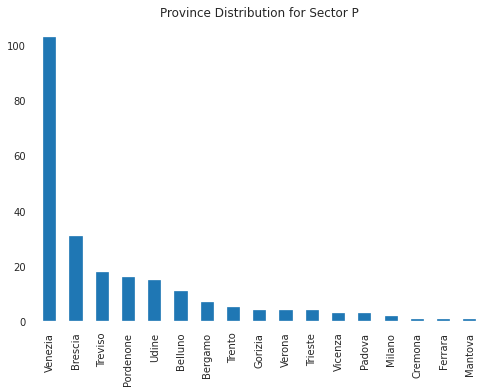

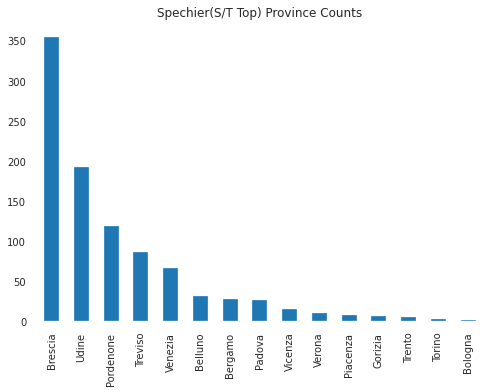

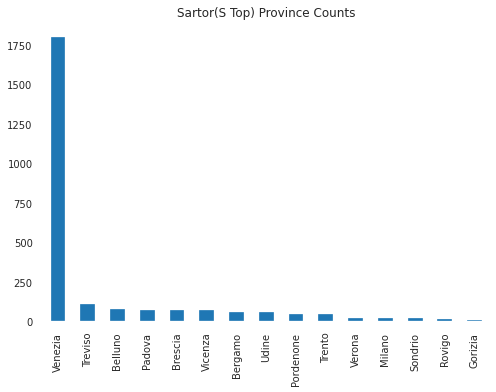

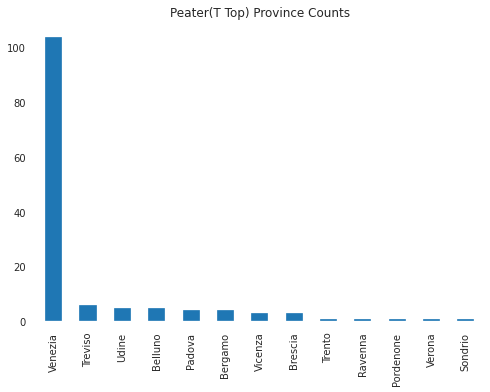

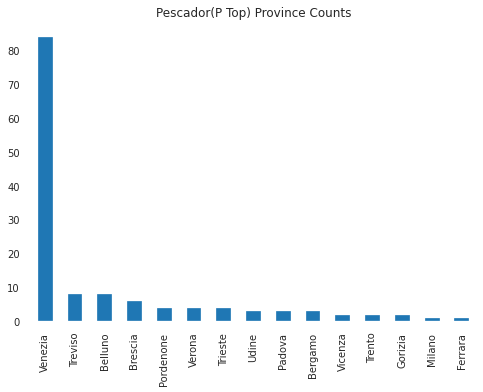

In [81]:
for sector in sectors:
    st = provenance_sector_profession[provenance_sector_profession[sector] == 1][["Apprentice Province", "Apprentice Profession"]]
    st['Apprentice Province'].value_counts()[:20].plot(kind='bar', title=f"Province Distribution for Sector {sector}")
    plt.show()
    
for sector in sectors:
    st = provenance_sector_profession[provenance_sector_profession[sector] == 1][["Apprentice Province", "Apprentice Profession"]]
    st_top = st["Apprentice Profession"].value_counts().index[0]
    st_top_df = provenance_sector_profession[provenance_sector_profession["Apprentice Profession"] == st_top][["Apprentice Province"]]
    st_top_df["Apprentice Province"].value_counts()[:15].plot(kind = 'bar', title = f"{st_top.title()}({sector} Top) Province Counts")
    plt.show()

### Apprentices Per Sector Over time ###

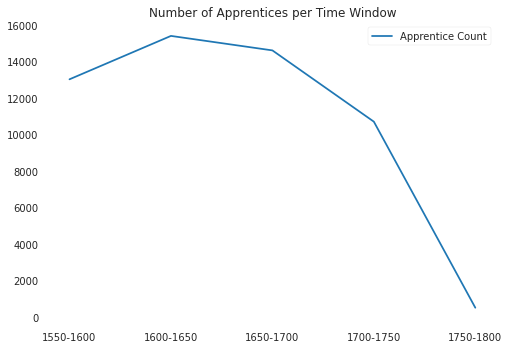

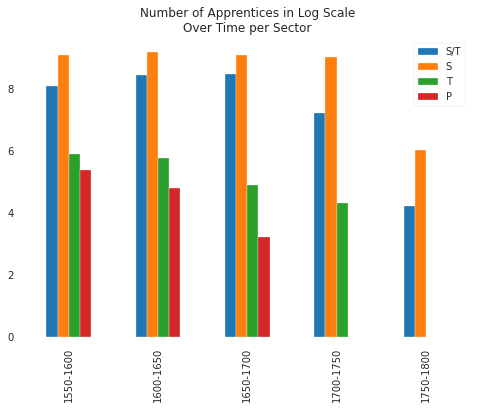

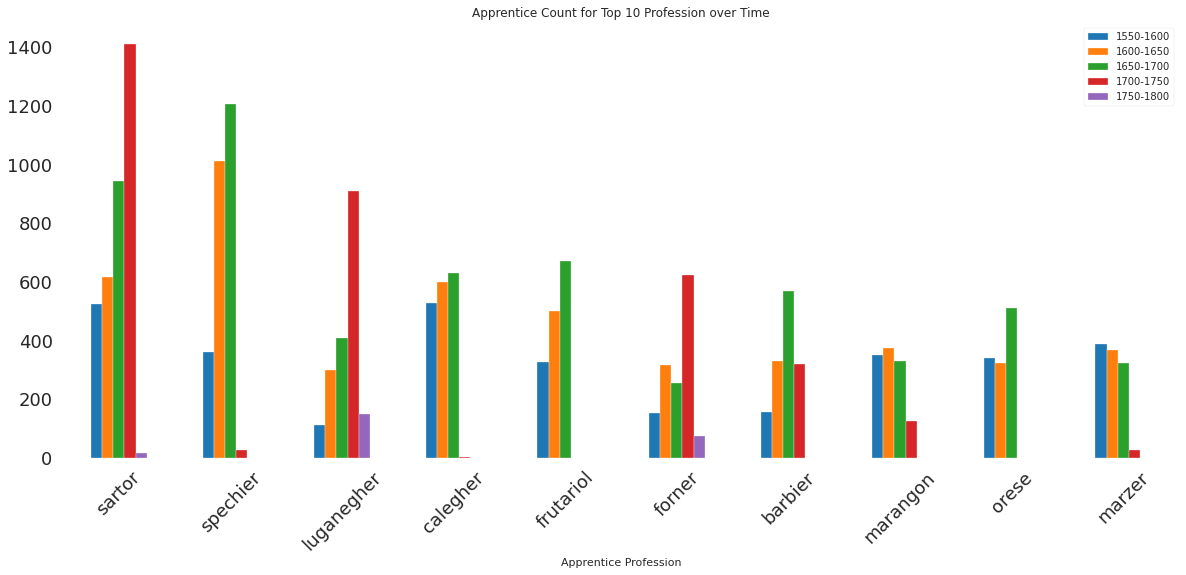

In [162]:
# First we look in number of contracts in total over time
gap = 50
start = 1550
end = 1800
df = pd.DataFrame(columns = ["Apprentice Count"])
for year in range(start, end, gap):
    temp = clnt.betweenYears(provenance_sector_profession, year, e_year = year + gap)
    df.loc[f"{year}-{year+gap}"] = len(temp)

df.plot(kind="line", title="Number of Apprentices per Time Window")
plt.show()

df = pd.DataFrame(columns = ["S/T", "S", "T", "P"])
for year in range(start, end, gap):
    temp = clnt.betweenYears(provenance_sector_profession, year, e_year = year + gap)
    df = df.append(pd.Series(temp[["S/T", "S", "T", "P"]].sum().apply(lambda x:np.log(x)), name = f"{year}-{year+gap}"))    
df.plot(kind="bar", title="Number of Apprentices in Log Scale\nOver Time per Sector")
plt.show()

# Then we look in profession scale
df = pd.DataFrame({"Apprentice Profession": provenance_sector_profession["Apprentice Profession"].unique()})
for year in range(start, end, gap):
    temp = clnt.betweenYears(provenance_sector_profession, year, e_year = year + gap)
    groups = temp.groupby("Apprentice Profession")[["Apprentice Profession"]].agg("count").copy()
    groups.columns = [f"{year}-{year+gap}"]
    df = df.merge(groups, on="Apprentice Profession", how = "left")

groups = provenance_sector_profession.groupby("Apprentice Profession")[["Apprentice Profession"]].agg("count").copy()
groups.columns = ["Total"]
df = df.merge(groups, on="Apprentice Profession", how = "left")
df = df[df["Apprentice Profession"].notna()]
df = df.set_index("Apprentice Profession")
df.sort_values("Total", ascending = False)[:10][df.keys()[:-1]].plot(kind='bar',
                                                                     figsize=(20,8),
                                                                     fontsize=18,
                                                                     rot=45,
                                                                     title="Apprentice Count for Top 10 Profession over Time")
plt.show()

### Gender Against Tag ###
Here we check the distirbution of genders per tag like Master, Apprentice, etc.

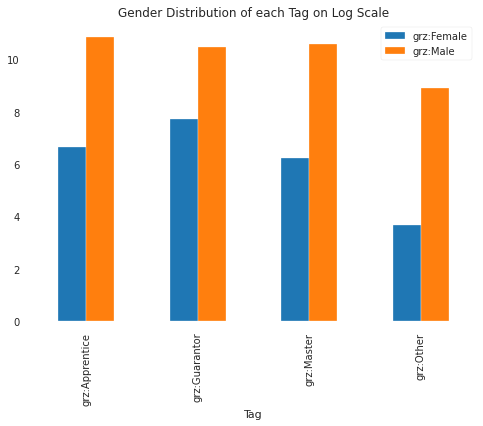

In [187]:
tag_n_gender = clnt.loadPickle("../data/pickles/clean_mentions.pkl")[["Tag", "Gender", "Person ID"]].drop_duplicates("Person ID")
# tag_n_gender = tag_n_gender.set_index("Person ID")
gender_dum = clnt.hotEncode(tag_n_gender, tag_n_gender["Gender"], group="Person ID")
tag_n_gender = tag_n_gender.merge(gender_dum, on="Person ID").set_index("Person ID")
tag_n_gender.groupby("Tag").sum().apply(np.log).plot(kind="bar", title="Gender Distribution of each Tag on Log Scale")

## Logistic Regression to assess Venetian or not ##

In [32]:
def confusionMatrix(y_test_values, y_predictions):
    cm = metrics.confusion_matrix(y_test_values, y_predictions)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);

### Prepare For Machine Learning ###

In [141]:
# Load frames
mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")[["Contract ID",
                                                                  "Geo Origin - Standard Form",
                                                                  "Tag"]]
locations = all_sheets["locations"][["Historical Name",
                                    "Province"]]
the_table = clnt.loadPickle("../data/pickles/table_of_all.pkl")

# Get slice
mentions_slice = mentions[mentions["Tag"] == "grz:Apprentice"].drop_duplicates("Contract ID")
mentions_slice = mentions_slice.merge(locations, left_on="Geo Origin - Standard Form",
                                      right_on="Historical Name", how="left")

# Add is Venetian?
mentions_prov = clnt.hotEncode(mentions_slice, mentions_slice.Province, operation="max")[["Contract ID", "Venezia"]]
mentions_prov.columns = ["Contract ID", "From Venezia"]
merged = the_table.merge(mentions_prov, on="Contract ID", how="left")

In [142]:
# Take the necessary part only, and convert four sector columns to one
merged["S"] = merged[["S/T", "S"]].max(axis=1)
merged["T"] = merged[["S/T", "T"]].max(axis=1)
merged = merged[['Contract ID', 'Has BoContract', 'Has Flee',
                 'Has Single Salary', 'Has Master Paying Salary', 'Has Whole Period',
                 'Has Ducati', 'Master Paid Accom', 'Master Paid Clothing',
                 'Master Paid Gen. Exp.', 'Master Paid Per. Care', 'Apprentice Age',
                 'Apprentice Male', 'Parent Label', 'S', 'T', 'P', 'Duration - Merged',
                 'Paid Salary in Goods', 'Total Payment Received', 'From Venezia']]
merged = merged.set_index("Contract ID")

# Preprocessing certain sections to fit the model, and loose na cells in data
le = LabelEncoder()
merged = merged.dropna()
# merged["Parent Label"] = merged[["Parent Label"]].apply(le.fit_transform)
merged["Paid Salary in Goods"] = merged["Paid Salary in Goods"].astype(float)

In [143]:
# merged_dummies = clnt.hotEncode(merged.reset_index(), merged["Parent Label"])
dummy_jobs = merged["Parent Label"].str.get_dummies()[['prod. e lav. di tessuti e filati', "commercio all'ingrosso e al minuto",
                                                       'prod. e lav. di generi alimentari','fabbr. e lav. di oggetti in vetro',
                                                       'prod. di calzature','lav. di metalli comuni', 'falegnameria', "prod. e lav. di capi d'abbigliamento e accessori"]]
merged = merged.reset_index().merge(dummy_jobs.reset_index(), on="Contract ID", how="left")
merged["Other Label"] = 1 - np.max(merged[['prod. e lav. di tessuti e filati', "commercio all'ingrosso e al minuto",
                                           'prod. e lav. di generi alimentari','fabbr. e lav. di oggetti in vetro',
                                           'prod. di calzature','lav. di metalli comuni', 'falegnameria',
                                           "prod. e lav. di capi d'abbigliamento e accessori"]], axis = 1)
del merged["Parent Label"]
merged

,Contract ID,Has BoContract,Has Flee,Has Single Salary,Has Master Paying Salary,Has Whole Period,Has Ducati,Master Paid Accom,Master Paid Clothing,Master Paid Gen. Exp.,...,From Venezia,prod. e lav. di tessuti e filati,commercio all'ingrosso e al minuto,prod. e lav. di generi alimentari,fabbr. e lav. di oggetti in vetro,prod. di calzature,lav. di metalli comuni,falegnameria,prod. e lav. di capi d'abbigliamento e accessori,Other Label
0,2288cdc8-4155-49a7-aa55-939c1d25740f,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0,0,0,1,0,0,0,0,0
1,9638a757-a06b-46d3-b2d5-15cf3acb4a55,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0,0,0,1,0,0,0,0,0
2,1f37bd42-bfa2-4664-84da-c1ce85c969ae,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0,0,0,0,0,0,0,0,1
3,3aa73470-cf2d-4048-a1a7-ee12801f7b99,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1,0,0,0,0,0,0,0,0
4,40565663-8d0b-47cf-90a5-3923b9627900,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24740,f7a08e57-1f6a-4a4c-83c8-192e40edd69b,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0,0,1,0,0,0,0,0,0
24741,4e2b0d6d-8047-4141-a277-f4fa56c6667a,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0,0,0,0,0,0,0,0,1
24742,3842c266-696a-4acb-a05e-031283cf27f6,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1,0,0,0,0,0,0,0,0
24743,754cc76f-0f8e-402d-8003-9019586fdecc,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0,0,1,0,0,0,0,0,0


In [148]:
# Clean the outliers
def cleanOutliers(df, loC, lower=0.02, higher=0.97):
    for a in loC:
        print(df[a].quantile([lower, higher]))
        df = df[(df[a] < df[a].quantile(higher)) & (df[a] > df[a].quantile(lower))]
    return df

merged = cleanOutliers(merged, ["Apprentice Age", "Duration - Merged", "Total Payment Received"])

0.02    10.0
0.98    20.0
Name: Apprentice Age, dtype: float64
0.02     522.8
0.98    2555.0
Name: Duration - Merged, dtype: float64
0.02     0.0
0.98    50.0
Name: Total Payment Received, dtype: float64


,Contract ID,Has BoContract,Has Flee,Has Single Salary,Has Master Paying Salary,Has Whole Period,Has Ducati,Master Paid Accom,Master Paid Clothing,Master Paid Gen. Exp.,...,From Venezia,prod. e lav. di tessuti e filati,commercio all'ingrosso e al minuto,prod. e lav. di generi alimentari,fabbr. e lav. di oggetti in vetro,prod. di calzature,lav. di metalli comuni,falegnameria,prod. e lav. di capi d'abbigliamento e accessori,Other Label
0,2288cdc8-4155-49a7-aa55-939c1d25740f,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0,0,0,1,0,0,0,0,0
1,9638a757-a06b-46d3-b2d5-15cf3acb4a55,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0,0,0,1,0,0,0,0,0
3,3aa73470-cf2d-4048-a1a7-ee12801f7b99,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1,0,0,0,0,0,0,0,0
5,377144ee-f1ef-40cb-9fa3-de368a8ae16f,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0,0,0,0,0,0,0,0,1
7,5400f5e1-fae1-401f-8872-90431e1df046,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24425,e8947b2c-eea4-49f3-96c7-580a4a96e1db,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0,0,1,0,0,0,0,0,0
24477,643ad547-b7e6-4d93-aceb-0d93e0a094d0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0,0,1,0,0,0,0,0,0
24585,574e29f5-1dd7-4f98-ae09-52c3ca56ba31,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1,0,0,0,0,0,0,0,0
24589,4d4accce-1611-475a-b64c-28797d218582,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1,0,0,0,0,0,0,0,0


### Train and Test the Model ###

In [35]:
# Split data to train and test
x_train, x_test, y_train, y_test = train_test_split(merged[merged.keys()[:-1]].copy(), merged["From Venezia"].copy(), test_size=0.25, random_state=42)
x_train = scale(x_train)
x_test = scale(x_test)

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      5354
         1.0       0.45      0.03      0.05       833

    accuracy                           0.86      6187
   macro avg       0.66      0.51      0.49      6187
weighted avg       0.81      0.86      0.81      6187



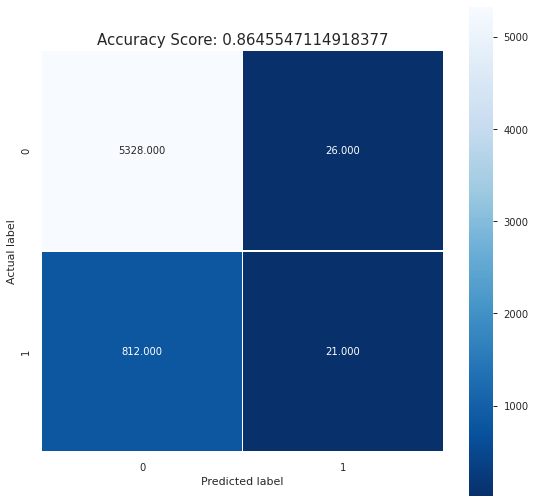

In [333]:
# Apply Logistic Regression and test results
logisticReg = LogisticRegression()
logisticReg.fit(x_train, y_train)
predictions = logisticReg.predict(x_test)
print(metrics.classification_report(y_test, predictions))

# Confusion matrix
confusionMatrix(y_test, predictions)

### Optimization and Improvements ###

In [334]:
# Use sampling to close the gap between classes
os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_sample(x_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=merged.keys()[:-1])
os_data_y= pd.DataFrame(data=os_data_y,columns=['From Venezia'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of non Venetians in oversampled data",len(os_data_y[os_data_y['From Venezia']==0]))
print("Number of Venetians",len(os_data_y[os_data_y['From Venezia']==1]))
print("Proportion of non Venetians data in oversampled data is ",len(os_data_y[os_data_y['From Venezia']==0])/len(os_data_X))
print("Proportion of Venetians data in oversampled data is ",len(os_data_y[os_data_y['From Venezia']==1])/len(os_data_X))

length of oversampled data is  32302
Number of non Venetians in oversampled data 16151
Number of Venetians 16151
Proportion of non Venetians data in oversampled data is  0.5
Proportion of Venetians data in oversampled data is  0.5


              precision    recall  f1-score   support

         0.0       0.91      0.70      0.79      5354
         1.0       0.22      0.56      0.32       833

    accuracy                           0.68      6187
   macro avg       0.57      0.63      0.55      6187
weighted avg       0.82      0.68      0.72      6187



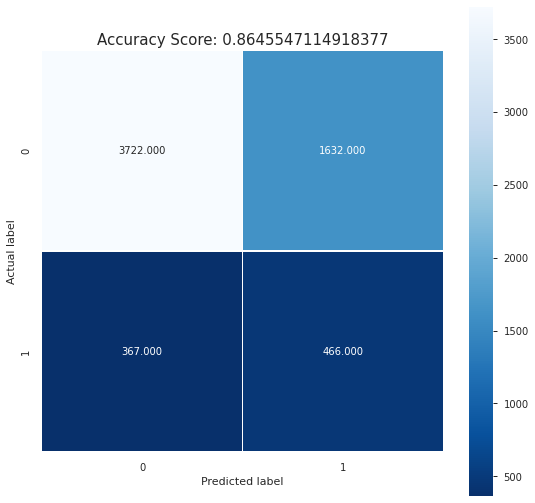

In [335]:
# Apply Logistic Regression and test results
logisticReg = LogisticRegression()
logisticReg.fit(os_data_X, os_data_y['From Venezia'])
predictions = logisticReg.predict(x_test)
print(metrics.classification_report(y_test, predictions))

# Confusion Matrix
confusionMatrix(y_test, predictions)

In [336]:
# Use feature selection to assess which columns matter more
logreg = LogisticRegression()
rfe = RFE(logreg)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
useful_features = list()
for b,f in zip(rfe.support_, os_data_X.keys()):
    if b:
        useful_features.append(f)
useful_features

['Has Master Paying Salary',
 'Has Whole Period',
 'Master Paid Clothing',
 'Master Paid Per. Care',
 'Apprentice Age',
 'Parent Label',
 'Sector',
 'Duration - Merged']

              precision    recall  f1-score   support

         0.0       0.91      0.70      0.79      5354
         1.0       0.23      0.56      0.32       833

    accuracy                           0.68      6187
   macro avg       0.57      0.63      0.56      6187
weighted avg       0.82      0.68      0.73      6187



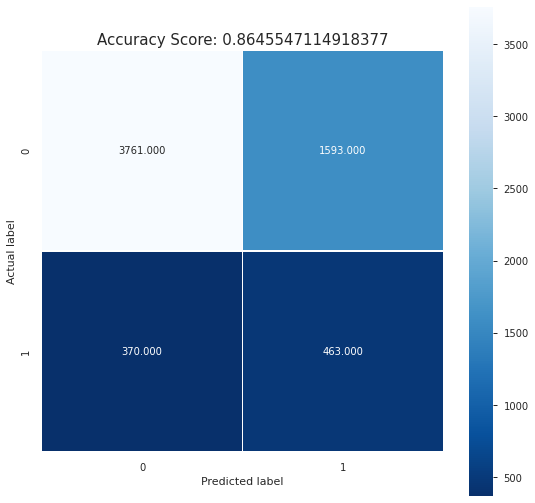

In [337]:
os_data_X = os_data_X[useful_features]
x_test = pd.DataFrame(data=x_test, columns = merged.keys()[:-1])
x_test = x_test[useful_features]
# Apply Logistic Regression and test results
logisticReg = LogisticRegression()
logisticReg.fit(os_data_X, os_data_y['From Venezia'])
predictions = logisticReg.predict(x_test)
print(metrics.classification_report(y_test, predictions))

# Confusion Matrix
confusionMatrix(y_test, predictions)

## Mapping the Geographical Data ##

In [94]:
# Here we use data from the dataset:
# https://github.com/sramazzina/italian-maps-shapefiles
# We merge the given individual provinces to a full map
folder = Path("../../italian-maps-shapefiles/all_together/")
shapefiles = folder.glob("*.shp")
gdf = pandas.concat([
    geopandas.read_file(shp)
    for shp in shapefiles
]).pipe(geopandas.GeoDataFrame)
# gdf.to_file('../data/italy_city_map.shp')
gdf["NOME_PRO"] = gdf["NOME_PRO"].apply(lambda x:x.title())
gdf = gdf.reset_index()
gdf

,index,COD_REG,COD_PRO,NOME_PRO,SHAPE_Leng,SHAPE_Area,geometry
0,0,4,21,Bolzano/Bozen,620108.330196,7.399211e+09,"POLYGON ((743386.080 5219948.900, 743472.190 5..."
1,1,4,22,Trento,594881.754084,6.208808e+09,"POLYGON ((716761.025 5154130.954, 716114.040 5..."
2,0,18,101,Crotone,255373.698192,1.734220e+09,"POLYGON ((1193390.541 4396845.642, 1193446.908..."
3,1,18,102,Vibo Valentia,202276.466347,1.148200e+09,"POLYGON ((1100602.110 4304206.521, 1100777.620..."
4,2,18,78,Cosenza,525877.852930,6.707462e+09,"MULTIPOLYGON (((1084873.044 4414392.388, 10848..."
...,...,...,...,...,...,...,...
105,0,11,42,Ancona,274879.906176,1.961606e+09,"MULTIPOLYGON (((863162.283 4840139.829, 863195..."
106,1,11,43,Macerata,320667.527842,2.781063e+09,"MULTIPOLYGON (((883619.250 4806680.750, 883626..."
107,2,11,44,Ascoli Piceno,204570.488201,1.229406e+09,"POLYGON ((889817.750 4780031.500, 890702.000 4..."
108,3,11,41,Pesaro E Urbino,330060.608373,2.567201e+09,"MULTIPOLYGON (((802389.500 4875193.750, 802452..."


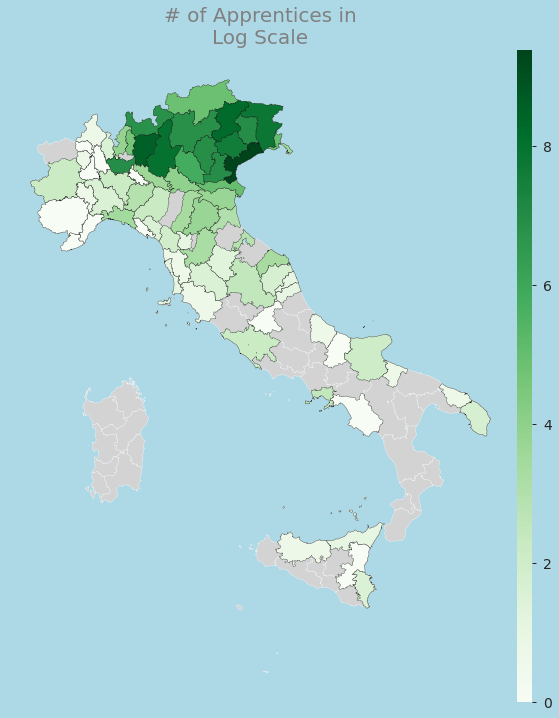

In [3]:
def plotMap(df, column="Count", empty_color="lightgrey", map_color_scale="Greens"):
    """Plots the given column in a data frame on italy map"""
    # Assign objects for control
    fig, ax = plt.subplots(1, figsize=(10,12), facecolor='lightblue')

    # Plot the values on empty map
    plt.title('# of Apprentices in\nLog Scale', loc='center', color="grey", fontsize=20)
    df.plot(ax=ax, color=empty_color)
    df.plot(column='Count', ax=ax, cmap=map_color_scale, edgecolors='black')

    # set an axis for the color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    # color bar
    vmax = df[column].max()
    mappable = plt.cm.ScalarMappable(cmap=map_color_scale, norm=plt.Normalize(vmin=0, vmax=vmax))
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.ax.tick_params(labelsize=14)

    # Close axis for visible sea color
    ax.axis('off')
    plt.show()
    
def filterFrame(df, filterParam: dict, s_year=1530, **kwargs):
    """Takes in a dataframe, a dictionary of columns and their desired value and extra arguments
    returns a dataframe with only the desired values on the columns"""
    df = clnt.betweenYears(df, s_year, **kwargs)
    if not filterParam:
        return df
    for key, val in filterParam.items():
        df = df[df[key] == val]
    return df

def filterNmap(df, filterParam=None, s_year=1530, column="Count", empty_color="lightgrey",
               map_color_scale="Greens", **kwargs):
    """Takes in a dataframe, a dictionary of columns and their desired values, plots the number of apprentices
    in provinces on an Italy map, using the data acquired by filtering the data frame accordingly"""
    gdf = gpd.read_file("../data/italy_city_map.shp")
    df = filterFrame(df, filterParam, s_year=s_year, **kwargs)
    values = pd.DataFrame(df["Apprentice Province"].value_counts().apply(np.log), columns = ["Apprentice Province"])
    values = values.reset_index()
    values.columns = ["Province", column]
    df = gdf.merge(values, left_on="NOME_PRO", right_on="Province", how="left")
    plotMap(df, column=column, empty_color=empty_color, map_color_scale=map_color_scale)
    

the_table = clnt.loadPickle("../data/pickles/table_of_all.pkl")
filterNmap(the_table)

In [115]:
the_table[the_table["Apprentice Province"].notna()]["Apprentice Profession"].unique()

array(['marangon', 'far casse da spechi', 'da perle false', ...,
       'frutariol, galiner, mandoler, mercante da ogio',
       'da chiodi, da colori, da pegola',
       'fabricator da ogio, specier da grosso'], dtype=object)

# Main Research #

From here on, we will be exploring the social network generated by the connections between people mentioned in each contract.

## Generation of the Graph ##

In [205]:
def getEdges(df, column="Person ID"):
    """Takes in a data frame. Returns a list of edges for networkx.
    The edges are generated with the assumption that everyone in the same contract is connected"""
    return list(combinations(list(df["Person ID"]),2))

In [206]:
# Prepare mentions to create nodes
# mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")[["Tag",
#                                                                   "Gender",
#                                                                   "Geo Origin - Standard Form",
#                                                                   "Person ID",
#                                                                   "Professions - Standard Form",
#                                                                   "Age - Standard Form"]]

mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")[["Person ID", "Tag"]]
mentions = mentions.drop_duplicates("Person ID")
mentions = mentions[mentions["Person ID"].notna()]
people = mentions.set_index("Person ID")
mentions = list(people.to_dict(orient="index").items())

# Extract the edgelist by assuming everyone in a contract is interconnected
edges = list()
for name, table in tqdm(sub_tables):
    edges += getEdges(table)

100%|██████████| 54088/54088 [00:09<00:00, 5579.04it/s]


In [207]:
# We generate the graph and store it here
G = nx.Graph()
G.add_nodes_from(mentions)
G.add_edges_from(edges)

# We remove the unconnected nodes, roughly 21 of them are present in this graph
G.remove_nodes_from([node for node in G.nodes if G.degree[node] == 0])
clnt.savePickle(G, "../data/pickles/social_network_graph.pkl")

## Exploration of the Graph ##

In [ ]:
G = clnt.loadPickle("../data/pickles/social_network_graph.pkl")

### Initial Check ###

In [215]:
print("Basics of the Graph")
print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")
print(f"Number of connected components: {nx.number_connected_components(G)}")
print(f"Average degree: {np.mean([G.degree[node] for node in G.nodes])}")

Basics of the Graph
Number of nodes: 137711
Number of edges: 156863
Number of connected components: 36701
Average degree: 2.2781477151425813


### Checking Components ###

In [216]:
sizes = [len(comp) for comp in nx.connected_components(G)]

print(f"Average Component Size: {np.mean(sizes)}")
print(f"Largest Component Size: {np.max(sizes)}")
print(f"Smallest Component Size: {np.min(sizes)}")

Average Component Size: 3.7522410833492277
Largest Component Size: 152
Smallest Component Size: 1


In [222]:
largest = max(nx.connected_components(G), key = len)

In [226]:
tags = [G.nodes[node]["Tag"] for node in list(largest)]
print("For the largest component")
print(f'Number of Apprentices: {sum([1 for tag in tags if tag == "grz:Apprentice"])}')
print(f'Number of Masters: {sum([1 for tag in tags if tag == "grz:Master"])}')
print(f'Number of Guarantors: {sum([1 for tag in tags if tag == "grz:Guarantor"])}')
print(f'Number of Others: {sum([1 for tag in tags if tag == "grz:Other"])}')

Number of Apprentices: 82
Number of Masters: 29
Number of Guarantors: 34
Number of Others: 7


In [229]:
adict = {"App": [], "Mas": [], "Gua": [], "Oth": []}
for comp in nx.connected_components(G):
    tags = [G.nodes[node]["Tag"] for node in list(comp)]
    adict["App"].append(sum([1 for tag in tags if tag == "grz:Apprentice"]))
    adict["Mas"].append(sum([1 for tag in tags if tag == "grz:Master"]))
    adict["Gua"].append(sum([1 for tag in tags if tag == "grz:Guarantor"]))
    adict["Oth"].append(sum([1 for tag in tags if tag == "grz:Other"]))
    
print("For all components, average")
print(f'Number of Apprentices: {np.mean(adict["App"])}')
print(f'Number of Masters: {np.mean(adict["Mas"])}')
print(f'Number of Guarantors: {np.mean(adict["Gua"])}')
print(f'Number of Others: {np.mean(adict["Oth"])}')

For all components, average
Number of Apprentices: 1.4446200376011553
Number of Masters: 1.0986349145799843
Number of Guarantors: 1.0061578703577558
Number of Others: 0.20282826081033214
